<h1>Lymphocyte Gating</h1>

Testing the performance of Immunova's automated gating algorithms at detecting lymphocyte populations gated using forward and sideward scatter. The accuracy, sensitivity, specificity and F1 score will be reported for each sample and then summarised as the average across all samples.

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
def visualise_manual_ellipse(data, x, y, centroid, width, height, angle, xlim, ylim):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [4]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [64]:
gating_performance = dict(sample_id=list(), method=list(), 
                          f1_score=list(), accuracy=list(), 
                          precision=list(), recall=list(),
                         time=list())

def audited_apply(sample_go, gate_name, manual_pop):
    # Apply function and measure time taken
    start = datetime.now()
    sample_go.apply(gate_name=gate_name)
    end = datetime.now()
    gating_performance['sample_id'].append(sample_go.id)
    gating_performance['method'].append(gate_name)
    gating_performance['time'].append((end-start).total_seconds())
    
    # Rate performance of result
    parent = sample_go.get_population_df(sample_go.populations[manual_pop].parent.name).copy()
    manual_pop_idx = sample_go.populations[manual_pop].index
    auto_pop_idx = sample_go.populations[gate_name].index
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    
    return pd.DataFrame(gating_performance)

In [65]:
x = pd.read_csv('algo_performance.csv')
gating_performance = x.to_dict('list')

<h2>HC1</h2>

In [7]:
hc1 = Gating(exp, 'hc1')

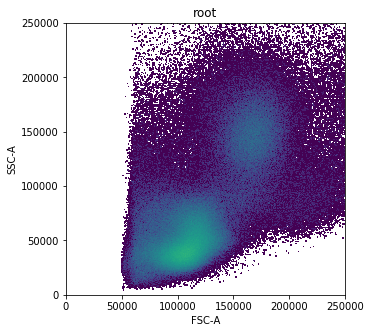

In [8]:
hc1.plotting.plot_population('root', 'FSC-A', 'SSC-A')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [9]:
child_populations = ChildPopulationCollection('geom')

In [10]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [11]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc1.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

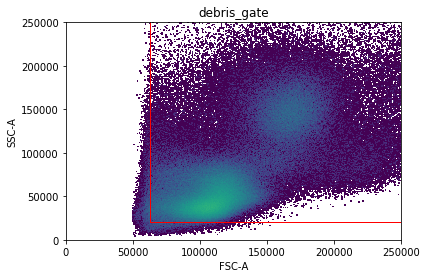

In [12]:
hc1.apply('debris_gate')

<h3>Manual Gate<\h3>

In [13]:
child_populations = ChildPopulationCollection('geom')

In [14]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

In [15]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(110000, 45000), width=100000, height=70000, angle=30)
hc1.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

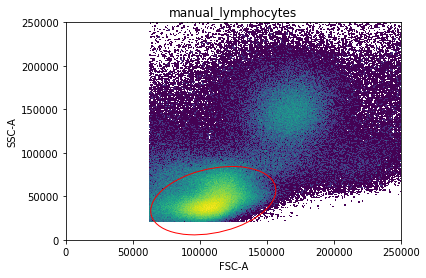

In [16]:
hc1.apply('manual_lymphocytes')

<h3>Mixture Model</h3>

In [15]:
child_populations = ChildPopulationCollection('geom')

In [16]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

In [17]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc1.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.92786,0.900831,0.997905,0.867004,6.1157


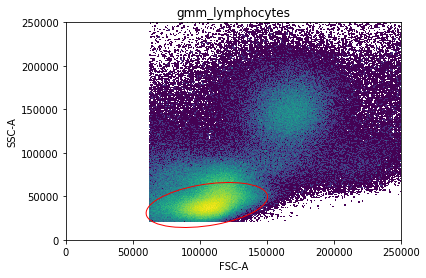

In [18]:
audited_apply(hc1, 'gmm_lymphocytes', 'manual_lymphocytes')

<h3>DBSCAN</h3>

In [19]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc1.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.92786,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.98565,0.978874,0.984963,0.986338,13.159312


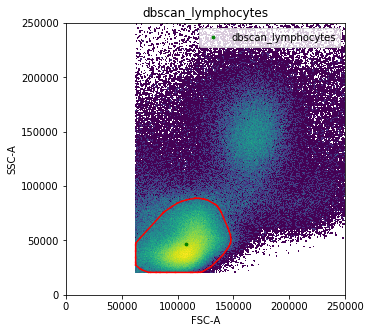

In [20]:
audited_apply(hc1, 'dbscan_lymphocytes', 'manual_lymphocytes')

<h3>HDBSCAN</h3>

In [21]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc1.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.927860,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.985650,0.978874,0.984963,0.986338,13.159312
2,hc1,hdbscan_lymphocytes,0.966983,0.949970,0.939622,0.995985,468.238852


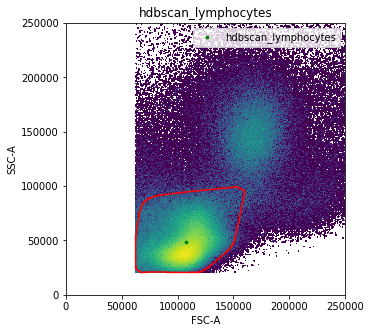

In [22]:
audited_apply(hc1, 'hdbscan_lymphocytes', 'manual_lymphocytes')

<h3>2D Density Threshold</h3>

In [17]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc1.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.927860,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.985650,0.978874,0.984963,0.986338,13.159312
2,hc1,hdbscan_lymphocytes,0.966983,0.949970,0.939622,0.995985,468.238852
3,hc1,dens2d_lymphocytes,0.221310,0.355091,0.989539,0.124587,3.719155


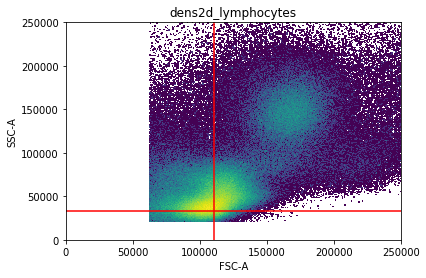

In [18]:
audited_apply(hc1, 'dens2d_lymphocytes', 'manual_lymphocytes')

In [21]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

<h2>HC2</h2>

In [24]:
hc = Gating(exp, 'hc4')

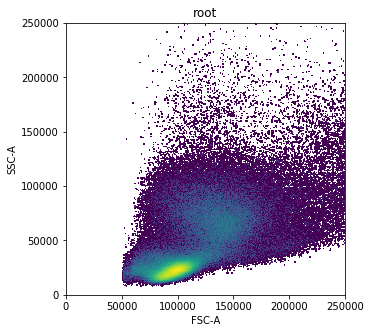

In [25]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [26]:
child_populations = ChildPopulationCollection('geom')

In [27]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [28]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

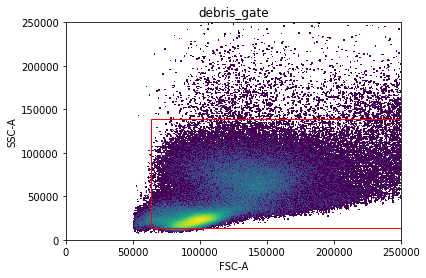

In [30]:
hc.apply('debris_gate')

<h3>Manual Gate<\h3>

In [31]:
child_populations = ChildPopulationCollection('geom')

In [32]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

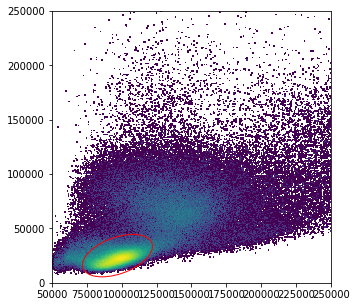

In [42]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

In [43]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

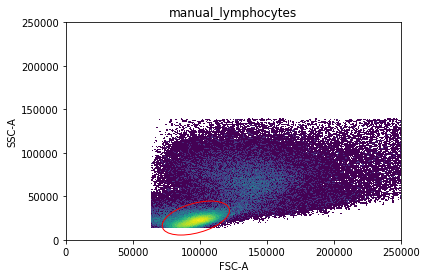

In [45]:
hc.apply('manual_lymphocytes')

<h3>Mixture Model</h3>

In [46]:
child_populations = ChildPopulationCollection('geom')

In [47]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

In [66]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.927860,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.985650,0.978874,0.984963,0.986338,13.159312
2,hc1,hdbscan_lymphocytes,0.966983,0.949970,0.939622,0.995985,468.238852
3,hc1,dens2d_lymphocytes,0.221310,0.355091,0.989539,0.124587,3.719155
4,hc4,gmm_lymphocytes,0.974289,0.961781,0.950037,0.999811,4.683574


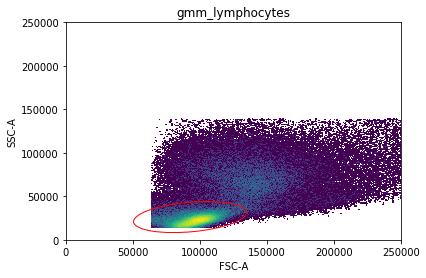

In [67]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

<h3>DBSCAN</h3>

In [68]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

ValueError: No points given

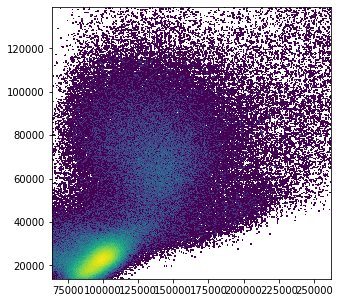

In [72]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [74]:
lst = [{'price': 99, 'barcode': '2342355'}, {'price': 88, 'barcode': '2345566'}]

maxPricedItem = max(lst, key=lambda x:x['price'])
minPricedItem = min(lst, key=lambda x:x['price'])

In [75]:
maxPricedItem

{'price': 99, 'barcode': '2342355'}

In [73]:
hc.populations['dbscan_lymphocytes']

Node('/root/cells/dbscan_lymphocytes', geom={'shape': 'cluster', 'x': 'FSC-A', 'y': 'SSC-A'}, index=array([], dtype=float64), population_name='dbscan_lymphocytes', prop_of_parent=0, prop_of_total=0, warnings=["Population ['dbscan_lymphocytes'] assigned to noise (i.e. population not found)"])

<h3>HDBSCAN</h3>

In [21]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc1.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.927860,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.985650,0.978874,0.984963,0.986338,13.159312
2,hc1,hdbscan_lymphocytes,0.966983,0.949970,0.939622,0.995985,468.238852


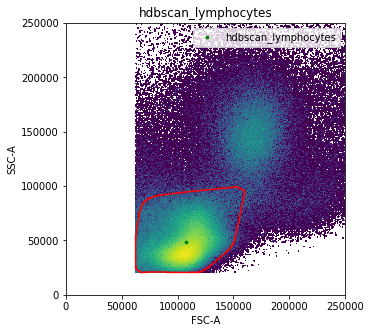

In [22]:
audited_apply(hc1, 'hdbscan_lymphocytes', 'manual_lymphocytes')

<h3>2D Density Threshold</h3>

In [17]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc1.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

,sample_id,method,f1_score,accuracy,precision,recall,time
0,hc1,gmm_lymphocytes,0.927860,0.900831,0.997905,0.867004,6.115700
1,hc1,dbscan_lymphocytes,0.985650,0.978874,0.984963,0.986338,13.159312
2,hc1,hdbscan_lymphocytes,0.966983,0.949970,0.939622,0.995985,468.238852
3,hc1,dens2d_lymphocytes,0.221310,0.355091,0.989539,0.124587,3.719155


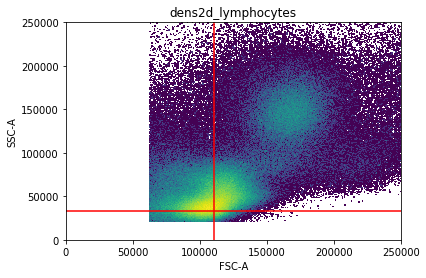

In [18]:
audited_apply(hc1, 'dens2d_lymphocytes', 'manual_lymphocytes')

In [21]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)